# load bitstream

In [1]:
import sys
import json
import requests
import numpy as np                                                                                         
import matplotlib.pyplot as plt
import pickle

from ipywidgets import interact, fixed
import ipywidgets as widgets
from IPython.display import Image, display

from time import sleep
from tqdm import tqdm
from attrdict import AttrDict
from datetime import date

sqclib = '/home/xilinx/jupyter_notebooks/nthu/Library'
sys.path.append(sqclib)
from sqckit.labber_toolv2 import InstrManager, hdf5_generator

qick_path = '/home/xilinx/jupyter_notebooks/nthu/Library/qick_lib'
sys.path.append(qick_path)
from qick import *


# bitfile_path = '/home/xilinx/jupyter_notebooks/nthu/multi-board-sync/top216_1.bit'
bitfile_path = '/home/xilinx/jupyter_notebooks/nthu/sinica-5q/top_216-pfb2.bit'
soc = QickSoc(bitfile = bitfile_path, external_clk = True)
port_map = {'0_230':0, '1_230':1, '2_230':2, '3_230':3,
                '0_231':4, '1_231':5, '2_231':6}

# soc = QickSoc(external_clk = True)
# port_map = {'0_230':0, '1_230':1, '2_230':2, '3_230':3,
#                 '0_231':4, '1_231':5, '2_231':6}


soccfg = soc
print(soc)

Load qick_lib to the environment.
Load sqckit to the environment.
Load labber_api to the environment.


resetting clocks: 245.76 491.52

QICK configuration:

	Board: ZCU216

	Software version: 0.2.220
	Firmware timestamp: Mon Jan 15 21:47:46 2024

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (9.524 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 32-bit DDS, range=6881.280 MHz
		DAC tile 2, blk 0 is 0_230, on JHC3
	1:	axis_signal_gen_v6 - envelope memory 65536 samples (9.524 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 32-bit DDS, range=6881.280 MHz
		DAC tile 2, blk 1 is 1_230, on JHC4
	2:	axis_signal_gen_v6 - envelope memory 65536 samples (9.524 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 32-bit DDS, range=6881.280 MHz
		DAC tile 2, blk 2 is 2_230, on JHC3
	3:	axis_signal_gen_v6 - envelope memory 65536 samples (9.524 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 32-bit DDS, range=6881.280 MHz
		DAC tile 2, blk 3 is 3_230, on JHC4
	4:	axis_signal_gen_v6 - envelope memory 65536 samples (9.524 us)


# Init instrument

In [4]:

a = InstrManager(server_ip='192.168.10.81')

a.add_instrument(sHardware='Rohde&Schwarz RF Source',
                    dComCfg={'name':'rf_lo',
                            'address': '192.168.10.84',
                            'interface': 'TCPIP'})
a.ctrl.rf_lo.setValue("LO Source", "External")
a.ctrl.rf_lo.setValue("LO Frequency", "10MHZ")

Activate rf_lo successfully.


'10MHZ'

# Build ADC level to power table

## setup

In [2]:

class ADC_readout(AveragerProgram):
    
    def initialize(self):
        
        cfg=self.cfg
        
        for adc_ch in self.cfg['adc_chs']:
            self.declare_readout(
                ch=adc_ch,
                length=cfg["readout_length"],
                freq=cfg["frequency"],
                sel=cfg['readout_sel'])
        
        self.synci(200)
        
    def body(self):
        
        self.trigger(adcs=self.cfg["adc_chs"],
                     adc_trig_offset=self.cfg["adc_trig_offset"])
        
        self.wait_all() 
        self.sync_all(self.cfg["relax_delay"]) 
        


max_power_LO = -1.6 # dBm     

In [ ]:

class (AveragerProgram):
    
    def initialize(self):
        
        cfg=self.cfg
        
        for adc_ch in self.cfg['adc_chs']:
            self.declare_readout(
                ch=adc_ch,
                length=cfg["readout_length"],
                freq=cfg["frequency"],
                sel=cfg['readout_sel'])
        
        self.synci(200)
        
    def body(self):
        
        self.trigger(adcs=self.cfg["adc_chs"],
                     adc_trig_offset=self.cfg["adc_trig_offset"])
        
        self.wait_all() 
        self.sync_all(self.cfg["relax_delay"]) 
        


max_power_LO = -1.6 # dBm     

## test-acquire_decimated

In [150]:
soccfg.adcfreq(4860, ro_ch=0)

4859.999997711182

In [ ]:

freq = 4675 # 4830, 4700
freq_round = soccfg.adcfreq(freq, ro_ch=0)

meas_cfg={
    "adc_chs": [0], # ADC 0
    "frequency": freq,
    "readout_length":500,
    "adc_trig_offset":soc.us2cycles(0), # relative to cavity tone
    "readout_sel": "product"
}

expt_cfg={"reps":1, "relax_delay":0.1, "soft_avgs": 1}

config={**meas_cfg, **expt_cfg}



a.ctrl.rf_lo.setValue(sQuant="Output", value = True)
a.ctrl.rf_lo.setValue(sQuant="Frequency", value = freq_round * 1e6)
print(a.ctrl.rf_lo.getValue(sQuant="Frequency")    )

# power_expts = np.linspace(-30, max_power_LO, 300)

power_expts = [max_power_LO]
# power_expts = [-15]

for power in power_expts:

    for freq in np.arange(4600, 4700, 5):
        
        config['frequency'] = freq
        freq_round = soccfg.adcfreq(freq, ro_ch=0)
        a.ctrl.rf_lo.setValue(sQuant="Frequency", value = freq_round * 1e6)

        
        if power > max_power_LO:
            print("power too large")
            break

        a.ctrl.rf_lo.setValue(sQuant='Power', value = power)
        prog = ADC_readout(soccfg, config)
        iq_list = prog.acquire_decimated(soc, load_pulses=True, progress=False)

        plt.figure()
        plt.plot(iq_list[0][0], label="I")
        plt.plot(iq_list[0][1], label="Q")
        plt.plot(np.abs(iq_list[0][0] + 1j * iq_list[0][1]), label="mag")

        plt.ylabel("a.u.")
        plt.xlabel("Clock ticks")
        plt.legend()  
        plt.title("freq: " + str(a.ctrl.rf_lo.getValue("Frequency") / 1e6) +\
                      " MHz, power: " + str(a.ctrl.rf_lo.getValue("Power")) + " dBm")

        plt.plot()
    
    
    
a.ctrl.rf_lo.setValue(sQuant="Output", value = False)    


In [152]:
a.ctrl.rf_lo.getValue(sQuant="Frequency")  

4859999998.0

## generate table

In [116]:

a.ctrl.rf_lo.setValue(sQuant="Output", value = True)

n_mag_avg = 1
ADCLevel2Power = dict()

for freq in tqdm(range(100, 1000, 5)):

    ADCLevel2Power[freq] = dict()

    a.ctrl.rf_lo.setValue(sQuant="Frequency", value = freq * 1e6)
    
    meas_cfg={
        "adc_chs": [3], # ADC 0
        "frequency": freq,
        "readout_length":500,
        "adc_trig_offset":0, 
        "readout_sel": "product"
    }
    expt_cfg={"reps":1, "relax_delay":0.1, "soft_avgs": 1}
    config={**meas_cfg, **expt_cfg}


    for power in np.arange(-50, max_power_LO, 0.5):
        power = round(float(power), 2)
        
        if power > max_power_LO:
            print("power too large")
            break

        a.ctrl.rf_lo.setValue(sQuant='Power', value = power)

        ampavg = []
        for i in range(n_mag_avg):
            prog = ADC_readout(soccfg, config)
            avgi, avgq = prog.acquire(soc, load_pulses=True, progress=False)
            ampavg.append(np.abs(avgi[0][0] + 1j*avgq[0][0]))
 
        ADCLevel2Power[freq][power] = round(float(np.mean(ampavg)), 2)
 
    
a.ctrl.rf_lo.setValue(sQuant="Output", value = False)

len(list(ADCLevel2Power.keys())), len(list(ADCLevel2Power[100].keys()))

100%|██████████| 180/180 [01:58<00:00,  1.52it/s]


(180, 97)

## plot table

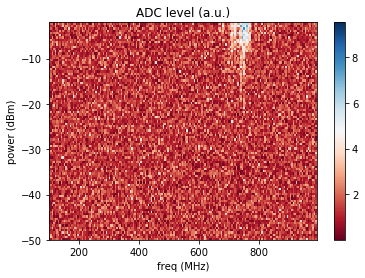

In [117]:
import matplotlib.pyplot as plt
import numpy as np
# ADCLevel2Power = ADCtable
x, y = np.meshgrid(list(ADCLevel2Power.keys()), list(ADCLevel2Power[100].keys()))

z = np.zeros(x.shape)

for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        z[i, j] = ADCLevel2Power[x[i, j]][y[i, j]]
        
fig, ax = plt.subplots()
ax.set_title('ADC level (a.u.)')

plt.pcolormesh(x, y, z, cmap='RdBu', vmin = np.abs(z).min(), vmax = np.abs(z).max())
plt.colorbar()


plt.xlabel("freq (MHz)")
plt.ylabel("power (dBm)")


plt.show()

In [108]:
ADCLevel2Power[100][-2.0], ADCLevel2Power[995][-50.0]

(30678.43, 103.89)

In [114]:
ADCLevel2Power[100][-2.0], ADCLevel2Power[995][-50.0]

(30508.81, 96.46)

## save table

In [115]:
import pickle

with open('ADCLevel2Power_balun-1000_top216-pfb2_adc-3.pkl', 'wb') as fp:
    pickle.dump(ADCLevel2Power, fp)

    
# check save    
with open('ADCLevel2Power_balun-1000_top216-pfb2_adc-3.pkl', 'rb') as fp:
    ADCtable = pickle.load(fp)

len(list(ADCtable.keys())), len(list(ADCtable[100].keys()))       

(180, 97)

## print table

In [17]:
import pickle
# check save    
with open('ADCLevel2Power_balun-1000_top216-pfb2_adc-0.pkl', 'rb') as fp:
    ADCtable = pickle.load(fp)

len(list(ADCtable.keys())), len(list(ADCtable[100].keys()))

(180, 97)

In [63]:
ADCtable

print('     ', end='')
for pwr in list(ADCtable[100].keys())[::8]:
    s = str(pwr)
    print(f'{s:>8}', end='')
print()

print('     ', end='')
for pwr in list(ADCtable[100].keys())[::8]:
    s = '________'
    print(f'{s:>8}', end='')
print()

for freq in list(ADCtable.keys())[::5]:
    s = str(freq) + "|"
    print(f'{s:>5}', end='')
    for pwr in list(ADCtable[100].keys())[::8]:
        s = str(round(ADCtable[freq][pwr]))
        print(f'{s:>8}', end='')
    print()

        -50.0   -46.0   -42.0   -38.0   -34.0   -30.0   -26.0   -22.0   -18.0   -14.0   -10.0    -6.0    -2.0
     ________________________________________________________________________________________________________
 100|     126     199     310     487     776    1231    1945    3074    4861    7702   12217   19346   30678
 125|     128     201     308     485     774    1228    1937    3064    4858    7698   12202   19399   30683
 150|     125     192     303     476     758    1201    1891    2992    4756    7514   11925   18980   30006
 175|     128     197     304     478     762    1207    1900    3008    4783    7562   11980   19046   30102
 200|     123     192     296     468     744    1176    1856    2934    4661    7368   11677   18580   29398
 225|     125     193     300     470     751    1185    1881    2977    4728    7478   11848   18787   29722
 250|     123     190     294     462     738    1165    1848    2923    4640    7340   11636   18455   29181
 275|     

# Build DAC gain to power table

## setup

  0%|          | 0/100 [00:00<?, ?it/s]

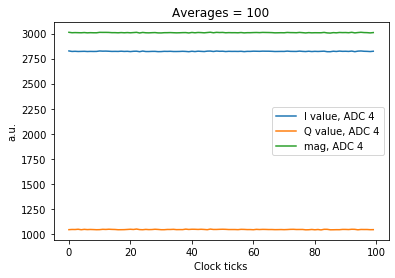

In [2]:
class LoopbackProgram(AveragerProgram):
    def initialize(self):
        cfg=self.cfg   
        res_ch = cfg["res_ch"]

        # set the nyquist zone
        self.declare_gen(ch=cfg["res_ch"], nqz=1)
        
        # configure the readout lengths and downconversion frequencies (ensuring it is an available DAC frequency)
        for ch in cfg["ro_chs"]:
            self.declare_readout(ch=ch, length=self.cfg["readout_length"],
                                 freq=self.cfg["pulse_freq"], gen_ch=cfg["res_ch"])

        # convert frequency to DAC frequency (ensuring it is an available ADC frequency)
        freq = self.freq2reg(cfg["pulse_freq"],gen_ch=res_ch, ro_ch=cfg["ro_chs"][0])
        phase = self.deg2reg(cfg["res_phase"], gen_ch=res_ch)
        gain = cfg["pulse_gain"]
        self.default_pulse_registers(ch=res_ch, freq=freq, phase=phase, gain=gain)

        style=self.cfg["pulse_style"]

        if style in ["flat_top","arb"]:
            sigma = cfg["sigma"]
            self.add_gauss(ch=res_ch, name="measure", sigma=sigma, length=sigma*5)
            
        if style == "const":
            self.set_pulse_registers(ch=res_ch, style=style, length=cfg["length"])
        elif style == "flat_top":
            # The first half of the waveform ramps up the pulse, the second half ramps down the pulse
            self.set_pulse_registers(ch=res_ch, style=style, waveform="measure", length=cfg["length"])
        elif style == "arb":
            self.set_pulse_registers(ch=res_ch, style=style, waveform="measure")
        
        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):

        
        self.measure(pulse_ch=self.cfg["res_ch"], 
                     adcs=self.ro_chs,
                     pins=[0], 
                     adc_trig_offset=self.cfg["adc_trig_offset"],
                     wait=True,
                     syncdelay=self.us2cycles(self.cfg["relax_delay"]))
        
        
        
        
config={"res_ch":6, # --Fixed
        "ro_chs":[4], # --Fixed
        "reps":1, # --Fixed
        "relax_delay":1.0, # --us
        "res_phase":0, # --degrees
        "pulse_style": "const", # --Fixed
        
        "length":200, # [Clock ticks]
        # Try varying length from 10-100 clock ticks
        
        "readout_length":100, # [Clock ticks]
        # Try varying readout_length from 50-1000 clock ticks

        "pulse_gain":3000, # [DAC units]
        # Try varying pulse_gain from 500 to 30000 DAC units

        "pulse_freq": 250, # [MHz]
        # In this program the signal is up and downconverted digitally so you won't see any frequency
        # components in the I/Q traces below. But since the signal gain depends on frequency, 
        # if you lower pulse_freq you will see an increased gain.

        "adc_trig_offset": 150, # [Clock ticks]
        # Try varying adc_trig_offset from 100 to 220 clock ticks

        "soft_avgs":100
        # Try varying soft_avgs from 1 to 200 averages

       }

 
    
prog =LoopbackProgram(soccfg, config)
iq_list = prog.acquire_decimated(soc, progress=True)


plt.figure(1)
for ii, iq in enumerate(iq_list):
    plt.plot(iq[0], label="I value, ADC %d"%(config['ro_chs'][ii]))
    plt.plot(iq[1], label="Q value, ADC %d"%(config['ro_chs'][ii]))
    plt.plot(np.abs(iq[0]+1j*iq[1]), label="mag, ADC %d"%(config['ro_chs'][ii]))
    
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.title("Averages = " + str(config["soft_avgs"]))
plt.legend();        

In [80]:
    
prog =LoopbackProgram(soccfg, config)
avgi, avgq = prog.acquire(soc, progress=True)

np.abs(avgi[0][0] + 1j*avgq[0][0])

  0%|          | 0/100 [00:00<?, ?it/s]

3005.755154356065

## generate table

In [5]:
 
config={"res_ch":6, # --Fixed
        "ro_chs":[4], # --Fixed
        "reps":100, # --Fixed
        "relax_delay":1.0, # --us
        "res_phase":0, # --degrees
        "pulse_style": "const", # --Fixed
        
        "length":200, # [Clock ticks]
        # Try varying length from 10-100 clock ticks
        
        "readout_length":100, # [Clock ticks]
        # Try varying readout_length from 50-1000 clock ticks

        "pulse_gain":3000, # [DAC units]
        # Try varying pulse_gain from 500 to 30000 DAC units

        "pulse_freq": 250, # [MHz]
        # In this program the signal is up and downconverted digitally so you won't see any frequency
        # components in the I/Q traces below. But since the signal gain depends on frequency, 
        # if you lower pulse_freq you will see an increased gain.

        "adc_trig_offset": 150, # [Clock ticks]
        # Try varying adc_trig_offset from 100 to 220 clock ticks

        "soft_avgs":1
        # Try varying soft_avgs from 1 to 200 averages

       }


DACGain2ADCLevel = dict()


for freq in tqdm(range(100, 1000, 5)):

    config['pulse_freq'] = freq
    DACGain2ADCLevel[freq] = dict()
  
    for gain in np.arange(10, 30000, 1000):
        
        config['pulse_gain'] = gain
        
        prog =LoopbackProgram(soccfg, config)
        avgi, avgq = prog.acquire(soc, load_pulses=True, progress=False)
      
        DACGain2ADCLevel[freq][gain] = round(float(np.abs(avgi[0][0] + 1j*avgq[0][0])), 2)
 
 
len(list(DACGain2ADCLevel.keys())), len(list(DACGain2ADCLevel[100].keys()))

  0%|          | 0/180 [00:00<?, ?it/s]

clearing streamer buffer
buffer cleared


100%|██████████| 180/180 [00:29<00:00,  6.08it/s]


(180, 30)

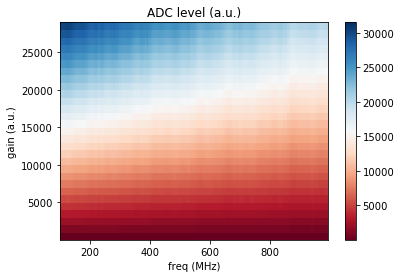

In [7]:
import matplotlib.pyplot as plt
import numpy as np
# ADCLevel2Power = ADCtable
x, y = np.meshgrid(list(DACGain2ADCLevel.keys()), list(DACGain2ADCLevel[100].keys()))

z = np.zeros(x.shape)

for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        z[i, j] = DACGain2ADCLevel[x[i, j]][y[i, j]]
        
fig, ax = plt.subplots()
ax.set_title('ADC level (a.u.)')

plt.pcolormesh(x, y, z, cmap='RdBu', vmin = np.abs(z).min(), vmax = np.abs(z).max())
plt.colorbar()


plt.xlabel("freq (MHz)")
plt.ylabel("gain (a.u.)")


plt.show()

In [10]:
import pickle# check save    
with open('ADCLevel2Power_balun-1000_top216-pfb2_adc-0.pkl', 'rb') as fp:
    ADCtbl = pickle.load(fp)

len(list(ADCtbl.keys())), len(list(ADCtbl[100].keys()))       

(180, 97)

In [29]:
from bisect import bisect, insort
def LinearInterpolation(x1, x2, y1, y2, x):
    return (y2 - y1) * ((x - x1) / (x2 - x1)) + y1


def ADCLevel2Power(freqs, adcLvls, ADCtbl):
    
    try:
        tblFreqs = list(ADCtbl.keys())
        pwrs = []

        for i in range(len(freqs)):

            freq = freqs[i]
            adcLvl = adcLvls[i]

            # find upper and lower freq.
            idx = bisect(tblFreqs, freq)
            tableFreq0 = tblFreqs[idx - 1]
            tableFreq1 = tblFreqs[idx]

            tblADCLvl0 = list(ADCtbl[tableFreq0].values())
            tblADCLvl1 = list(ADCtbl[tableFreq1].values())
            tblPwrs0 = list(ADCtbl[tableFreq0].keys())
            tblPwrs1 = list(ADCtbl[tableFreq1].keys())


            # linear interpolation.
            idx = bisect(tblADCLvl0, adcLvl) 
            p0 = LinearInterpolation(tblADCLvl0[idx-1], tblADCLvl0[idx], 
                    tblPwrs0[idx - 1], tblPwrs0[idx], adcLvl)

            # linear interpolation.
            idx = bisect(tblADCLvl1, adcLvl)
            p1 = LinearInterpolation(tblADCLvl1[idx-1], tblADCLvl1[idx], 
                    tblPwrs1[idx - 1], tblPwrs1[idx], adcLvl)

            # linear interpolation.
            p = LinearInterpolation(tableFreq0, tableFreq1, p0, p1, freq)

            pwrs.append(p)
        return pwrs
    except:
        return [None]
    

In [30]:

DACGain2Power = {}

for freq in list(DACGain2ADCLevel.keys()):
    
    DACGain2Power[freq] = {}
    
    for gain in list(DACGain2ADCLevel[100].keys()):
        
        freqs = [freq]
        adcLvls = [ DACGain2ADCLevel[freq][gain] ]
        
        DACGain2Power[freq][gain] = ADCLevel2Power(freqs, adcLvls, ADCtbl)[0]
        
 



## print table

In [33]:
 
gainidx_step = 2

print('     ', end='')
for gain in list(DACGain2Power[100].keys())[::gainidx_step]:
    s = str(gain)
    print(f'{s:>8}', end='')
print()

print('     ', end='')
for gain in list(DACGain2Power[100].keys())[::gainidx_step]:
    s = '________'
    print(f'{s:>8}', end='')
print()

for freq in list(DACGain2Power.keys())[::5]:
    s = str(freq) + "|"
    print(f'{s:>5}', end='')
    for gain in list(DACGain2Power[100].keys())[::gainidx_step]:
     
        s = str(round(DACGain2Power[freq][gain], 2))
        print(f'{s:>8}', end='')
    print()

           10    2010    4010    6010    8010   10010   12010   14010   16010   18010   20010   22010   24010   26010   28010
     ________________________________________________________________________________________________________________________
 100|  -50.18   -25.0  -18.98  -15.44  -12.94  -11.03   -9.42   -8.09   -6.93   -5.92   -5.01   -4.18   -3.41   -2.72   -2.08
 125|  -50.18  -24.94  -18.95  -15.43  -12.93  -11.01   -9.41   -8.08   -6.92   -5.93   -5.01   -4.18   -3.41   -2.72   -2.08
 150|  -50.18   -25.0  -19.02  -15.49  -12.99  -11.09   -9.49   -8.16   -6.99   -6.01   -5.09   -4.26   -3.49    -2.8   -2.16
 175|  -50.18  -25.04  -19.06  -15.54  -13.04  -11.12   -9.52    -8.2   -7.03   -6.03   -5.11   -4.27   -3.51   -2.81   -2.18
 200|  -50.18  -25.13  -19.14  -15.61  -13.11   -11.2    -9.6   -8.27    -7.1   -6.11    -5.2   -4.36    -3.6    -2.9   -2.27
 225|  -50.18  -25.22  -19.23   -15.7  -13.21  -11.29   -9.69   -8.36   -7.19   -6.17   -5.26   -4.43   -3.66   -2.96 

## save table

In [34]:
import pickle

with open('DACGain2Power_balun-1000_top216-dac6-adc4.pkl', 'wb') as fp:
    pickle.dump(DACGain2Power, fp)

    
# check save    
with open('DACGain2Power_balun-1000_top216-dac6-adc4.pkl', 'rb') as fp:
    dactbl = pickle.load(fp)

len(list(dactbl.keys())), len(list(dactbl[100].keys())) 

(180, 30)

In [35]:
dactbl

{100: {10: -50.18026413550446,
  1010: -30.998323426306964,
  2010: -24.99518477043673,
  3010: -21.469338996548977,
  4010: -18.976971444591292,
  5010: -17.036710320960847,
  6010: -15.440423929137335,
  7010: -14.11005668648016,
  8010: -12.941669225454824,
  9010: -11.931082214765102,
  10010: -11.027019650655022,
  11010: -10.196247888978633,
  12010: -9.424211243790223,
  13010: -8.730780136597875,
  14010: -8.094065148974293,
  15010: -7.494280821193733,
  16010: -6.928876949310776,
  17010: -6.411305463129915,
  18010: -5.916402535657686,
  19010: -5.460398930701213,
  20010: -5.014077729796422,
  21010: -4.58747160648547,
  22010: -4.183493636952808,
  23010: -3.792756388803839,
  24010: -3.413737893383028,
  25010: -3.0564122417911226,
  26010: -2.715777038579911,
  27010: -2.3888904677189258,
  28010: -2.0817499246898072,
  29010: None},
 105: {10: -50.18481651100105,
  1010: -30.933247461736627,
  2010: -24.9549376450116,
  3010: -21.447307953417933,
  4010: -18.96581110888

# Apply table

In [540]:

class Onetone(AveragerProgram):
    def initialize(self):
        cfg=self.cfg
        
        for adc_ch in self.cfg['adc_chs']:
            self.declare_readout(
                ch=adc_ch,
                length=cfg["readout_length"],
                freq=cfg["frequency"],
                sel=cfg['readout_sel'],
                gen_ch=cfg["dac_ch"]
            )
        
        # set default setup to register
        freq=self.freq2reg(cfg["frequency"], gen_ch=cfg["dac_ch"], ro_ch=cfg["adc_chs"][0]) #Synchronize frequency
        phase=self.deg2reg(deg=cfg["phase"], gen_ch=cfg["dac_ch"])
        gain=cfg["power"]
        self.default_pulse_registers(ch=cfg["dac_ch"], freq=freq, phase=phase, gain=gain)
        
        
        if(cfg["style"] == "const"):
            self.set_pulse_registers(ch=cfg["dac_ch"], style="const", length=cfg["length"])
            
        elif(cfg["style"] == "flat_top"):
        
            sig = cfg['sigma']
            self.add_gauss(ch=cfg["dac_ch"], name='measure', sigma=sig, length=sig*5)
            self.set_pulse_registers(ch=cfg["dac_ch"],
                                     style='flat_top',
                                     waveform="measure",
                                     length=cfg["length"])         

        self.synci(200)
        
    def body(self):
        
        self.trigger(adcs=self.cfg["adc_chs"],
                     adc_trig_offset=self.cfg["adc_trig_offset"])
        
        self.pulse(ch=self.cfg["dac_ch"])
                
        self.wait_all()
                
        self.sync_all(self.cfg["relax_delay"]) 

In [13]:
from bisect import bisect, insort
def LinearInterpolation(x1, x2, y1, y2, x):
    return (y2 - y1) * ((x - x1) / (x2 - x1)) + y1


def ADCLevel2Power(freqs, adcLvls, ADCtbl):
    
    tblFreqs = list(ADCtbl.keys())
    pwrs = []
    
    for i in range(len(freqs)):
        
        freq = freqs[i]
        adcLvl = adcLvls[i]
        
        # find upper and lower freq.
        idx = bisect(tblFreqs, freq)
        tableFreq0 = tblFreqs[idx - 1]
        tableFreq1 = tblFreqs[idx]
    
        tblADCLvl0 = list(ADCtbl[tableFreq0].values())
        tblADCLvl1 = list(ADCtbl[tableFreq1].values())
        tblPwrs0 = list(ADCtbl[tableFreq0].keys())
        tblPwrs1 = list(ADCtbl[tableFreq1].keys())
        
        
        # linear interpolation.
        idx = bisect(tblADCLvl0, adcLvl) 
        p0 = LinearInterpolation(tblADCLvl0[idx-1], tblADCLvl0[idx], 
                tblPwrs0[idx - 1], tblPwrs0[idx], adcLvl)

        # linear interpolation.
        idx = bisect(tblADCLvl1, adcLvl)
        p1 = LinearInterpolation(tblADCLvl1[idx-1], tblADCLvl1[idx], 
                tblPwrs1[idx - 1], tblPwrs1[idx], adcLvl)

        # linear interpolation.
        p = LinearInterpolation(tableFreq0, tableFreq1, p0, p1, freq)
        
        pwrs.append(p)
    
    return pwrs


## ADC1

In [552]:
with open('ADCLevel2Power-ADC1-step_1MHz_0p02dBm-float.pkl', 'rb') as fp:
    ADC1table = pickle.load(fp)

len(list(ADC1table.keys())), len(list(ADC1table[100].keys()))   

(900, 670)

In [ ]:
ADC1table[100]

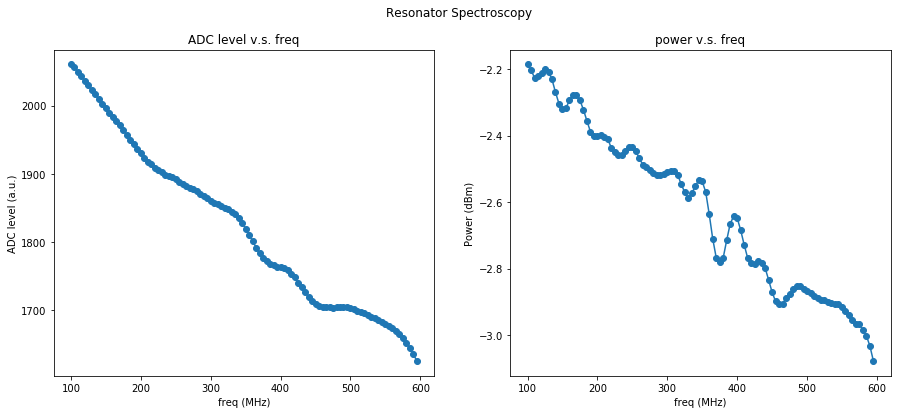

In [551]:


pulse_cfg={
    "dac_ch": 6, # DAC 0
    "frequency":400,
    "power":30000,
    "phase": 0,
    "style": ["flat_top", "const"][1],
    "length": soc.us2cycles(1),
    "sigma": soc.us2cycles(0.05)
}

meas_cfg={
    "adc_chs": [1], # ADC 1
    "readout_length":soc.us2cycles(0.8),
    "adc_trig_offset":soc.us2cycles(0.35), # relative to cavity tone
    "relax_delay": soc.us2cycles(1),
    "readout_sel": "product"
}

expt_cfg={"reps":1, "relax_delay":1, "soft_avgs": 1,
         "start":100, "step":5, "expts":100}


# expt_cfg={"reps":1, "relax_delay":1, "soft_avgs": 10,
#          "start":300, "step":1, "expts":100}

config={**pulse_cfg, **meas_cfg, **expt_cfg}

fpts = expt_cfg["start"] + expt_cfg["step"] * np.arange(expt_cfg["expts"])


amps = []
for f in fpts:
    
    config["frequency"]=f

    prog = Onetone(soccfg, config)
    
    avgi, avgq = prog.acquire(soc, load_pulses=True)
    amp=np.abs(avgi[0][0] + 1j*avgq[0][0])

#     iq_list = prog.acquire_decimated(soc, load_pulses=True, progress=False)
#     amp = round(float(np.mean(np.abs(iq_list[0][0] + 1j * iq_list[0][1]))), 2)

    amps.append(amp)

amps=np.array(amps)

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle("Resonator Spectroscopy")

ax[0].plot(fpts, amps, 'o-')
ax[0].set_title('ADC level v.s. freq')
ax[0].set_xlabel('freq (MHz)')
ax[0].set_ylabel('ADC level (a.u.)')

ax[1].plot(fpts, ADCLevel2Power(fpts, amps, ADC1table), 'o-')
ax[1].set_title('power v.s. freq')
ax[1].set_xlabel('freq (MHz)')
ax[1].set_ylabel('Power (dBm)')

# plt.tight_layout()
plt.show()

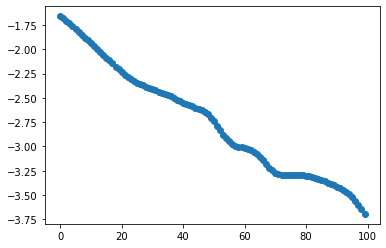

In [542]:
fpts100 = [350] * len(fpts)
# fpts100 = np.linspace(350, 450, len(fpts))
plt.plot(ADCLevel2Power(fpts100, amps, ADC1table), 'o-')

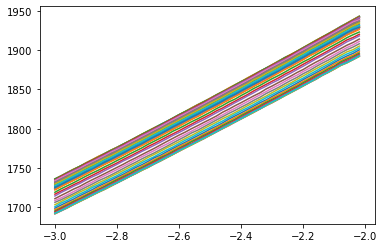

In [535]:

l = 600
u = 650
# freq = 360
for freq in range(350, 400):
    plt.plot(list(ADC1table[freq].keys())[l:u], list(ADC1table[freq].values())[l:u])

In [532]:
l = 600
u = 650
list(ADC1table[freq].values())[l:u]

[1725.48,
 1729.38,
 1733.17,
 1736.96,
 1740.95,
 1745.24,
 1749.46,
 1753.04,
 1757.44,
 1761.11,
 1765.44,
 1769.12,
 1772.94,
 1777.35,
 1781.45,
 1785.46,
 1789.74,
 1793.66,
 1797.76,
 1802.16,
 1806.58,
 1810.57,
 1814.3,
 1818.89,
 1822.99,
 1827.32,
 1830.99,
 1835.59,
 1839.73,
 1844.04,
 1848.43,
 1852.42,
 1856.69,
 1861.5,
 1865.14,
 1869.64,
 1874.13,
 1878.29,
 1882.48,
 1886.9,
 1891.03,
 1895.66,
 1900.01,
 1904.39,
 1909.02,
 1912.97,
 1917.33,
 1921.87,
 1926.32,
 1930.84]

## ADC0

In [386]:
with open('ADCLevel2Power-ADC0-step_1MHz_0p01dBm-float.pkl', 'rb') as fp:
    ADC0table = pickle.load(fp)

len(list(ADC0table.keys())), len(list(ADC0table[100].keys()))   

(900, 1340)

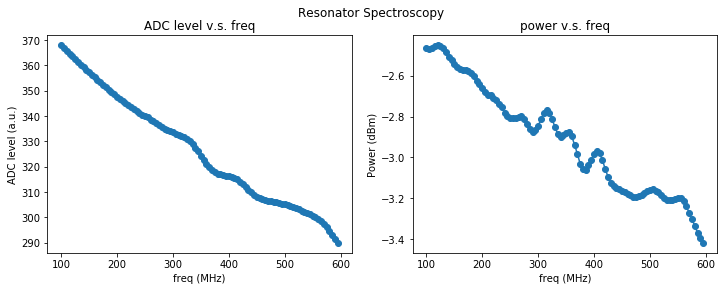

In [486]:
pulse_cfg={
    "dac_ch": 4, # DAC 2
    "frequency":400,
    "power":30000,
    "phase": 0,
    "style": ["flat_top", "const"][1],
    "length": soc.us2cycles(1),
    "sigma": soc.us2cycles(0.05)
}

meas_cfg={
    "adc_chs": [0], # ADC 0
    "readout_length":soc.us2cycles(0.8),
    "adc_trig_offset":soc.us2cycles(0.35), # relative to cavity tone
    "relax_delay": soc.us2cycles(1),
    "readout_sel": "product"
}

expt_cfg={"reps":1, "relax_delay":1, "soft_avgs": 10,
         "start":100, "step":5, "expts":100}

# expt_cfg={"reps":1, "relax_delay":1, "soft_avgs": 10,
#          "start":300, "step":1, "expts":100}

# expt_cfg={"reps":1, "relax_delay":1, "soft_avgs": 10,
#          "start":500, "step":1, "expts":100}

config={**pulse_cfg, **meas_cfg, **expt_cfg}

fpts = expt_cfg["start"] + expt_cfg["step"] * np.arange(expt_cfg["expts"])

amps = []
for f in fpts:
    
    config["frequency"]=f

    prog = Onetone(soccfg, config)
    avgi, avgq = prog.acquire(soc, load_pulses=True)
    amp=np.abs(avgi[0][0] + 1j*avgq[0][0])
    amps.append(amp)

amps=np.array(amps)


fig, ax = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle("Resonator Spectroscopy")

ax[0].plot(fpts, amps, 'o-')
ax[0].set_title('ADC level v.s. freq')
ax[0].set_xlabel('freq (MHz)')
ax[0].set_ylabel('ADC level (a.u.)')

ax[1].plot(fpts, ADCLevel2Power(fpts, amps, ADC0table), 'o-')
ax[1].set_title('power v.s. freq')
ax[1].set_xlabel('freq (MHz)')
ax[1].set_ylabel('Power (dBm)')

# plt.tight_layout()
plt.show()